#### Copyright 2020 Connaissance Publishing.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# **Understanding Deep Learning: Application in Rare Event Prediction**

Author: Chitta Ranjan, Ph.D.

[ProcessMiner, Inc.](https://processminer.com)

cranjan@processminer.com

LinkedIn: https://www.linkedin.com/in/chitta-ranjan-b0851911/

Medium: https://medium.com/@cran2367


---

# Convolutional Classifier pretrained with Autoencoder

# Connection

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_path = 'gdrive/My Drive/understanding-deep-learning/codebase'
import os
os.chdir(root_path)

Mounted at /content/gdrive


In [ ]:
os.getcwd()

# Libraries

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input 
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Conv1DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.python.keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

# user-defined libraries
import utilities.datapreprocessing as dp
import utilities.performancemetrics as pm
import utilities.simpleplots as sp
import utilities.reconstructionperformance as rp

from numpy.random import seed
seed(1)

SEED = 123  # used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

from pylab import rcParams
rcParams['figure.figsize'] = 6, 4
plt.rcParams.update({'font.size': 22})

In [ ]:
# Check the tensorflow version.
tf.__version__

'2.3.0'

# Data Preparation

The data is taken from https://arxiv.org/abs/1809.10717. Please use this source for any citation.

In [ ]:
'''Download data here:
https://docs.google.com/forms/d/e/1FAIpQLSdPCkTFW1wTp6tAP1C1BhT7HWTQ60-GfCGvWs9Ca4WbR0FIdg/viewform
'''
df = pd.read_csv("data/processminer-sheet-break-rare-event-dataset.csv")
df.head(n=5)  # visualize the data.

,DateTime,SheetBreak,RSashScanAvg,CT#1 BLADE PSI,P4 CT#2 BLADE PSI,Bleached GWD Flow,ShwerTemp,BlndStckFloTPD,C1 BW SPREAD CD,RS BW SPREAD CD,C1 BW SPREAD MD,RS BW SPREAD MD,C1 BW SCAN AVG,RS BW SCAN AVG,CoatBrkFlo,Clay Flow,CouchLoVac,COUCH VAC,4PrsTopLd,4PrsBotLod,CalndrDrw,2DryrDrw,3DryrDrw,4DryrDraw,1PrsTopDrw,4PrsBotDrw,FanPmpSpd,FlBxHdrVac,FlatBxVac,Grade&Bwt,UnblGWDFlo,Hdbox pH,HdBxLiqLvl,"TotHead""",HorzSlcPos,KraftFlow,CouchLoad,C1MoSprdCD,RSMoSprdCD,C1MoSprdMD,RSMoSprdMD,RL MoisAct,PrScrRjFlo,RwBrkFlo,RcycFbrFlo,RetnAidFlo,RUSH DRAG,Rush/Drag,SilicaFlo,HBxSlcTemp,SodAlumFlo,CouchSpd,MachSpd,1PrsTopSpd,4PrsBotSpd,WtNStarFlo,BasWgtFlo,TMP Flow,HBxTotHead,TrayCons,UpprHdTmpRL,VertSlcPos,EventPress
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,-0.059966,-0.038189,0.877951,-0.052959,-13.306135,0.101068,0.041800,0.199901,-2.327329,-0.944167,3.075199,0.123154,-0.104334,-0.570710,-9.784456,0.355960,15.842819,-0.451974,-0.105282,96,-134.277862,0.058726,-0.021645,9.366755,0.002151,-69.187583,4.232571,-0.225267,-0.196872,-0.072449,-0.103732,-0.720746,-5.412436,76.679042,-0.632727,1351.632859,-0.657095,-0.434947,-108.775969,0.084856,10.210182,11.295155,29.984624,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230658,-0.128733,-18.758079,0.000732,-0.061114,-0.059966,-0.038189,0.873273,-0.014244,-13.306135,0.101108,0.041447,0.304313,-2.340627,-0.939994,3.075199,0.123154,-0.104334,-0.574861,-9.784456,0.360160,16.491684,-0.450451,-0.092430,96,-134.480194,0.058759,-0.004579,9.350215,0.002149,-68.585197,4.311490,-0.225267,-0.196872,-0.059103,-0.083895,-0.720746,-8.343222,78.181598,-0.632727,1370.378949,-0.875628,-1.125819,-108.848967,0.085146,12.534340,11.290761,29.984624,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,-0.030057,-0.018352,1.004910,0.065150,-9.619596,0.101148,0.041095,0.252839,-2.353925,-0.935824,3.075199,0.123154,-0.104334,-0.579013,-9.784456,0.364356,15.972885,-0.448927,-0.097144,96,-133.946587,0.058791,-0.084658,9.037409,0.002148,-67.838187,4.809914,-0.225267,-0.186801,-0.048696,-0.073823,-0.720746,-1.085166,79.684154,-0.632727,1368.123089,-0.037775,-0.519541,-109.086577,0.085436,18.582893,11.286366,29.984624,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,-0.019986,-0.008280,0.930037,-0.067199,-15.196531,0.101188,0.040742,0.072873,-2.367223,-0.931651,3.075199,0.123154,-0.104334,-0.583165,-9.784456,0.368556,15.608688,-0.447404,-0.160073,96,-134.002586,0.058824,-0.055118,9.020625,0.002146,-67.091148,5.308343,-0.225267,-0.186801,-0.047017,-0.063752,-0.720746,6.172891,81.186702,-0.632727,1365.691449,-0.987410,0.674524,-109.562774,0.085726,17.719032,11.281972,29.984624,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,-0.030057,-0.008280,0.828410,-0.018472,-14.609266,0.101229,0.040390,0.171033,-2.380521,-0.927478,3.075199,0.123154,-0.104334,-0.587316,-9.784456,0.372756,15.606125,-0.445880,-0.131630,96,-133.145706,0.058856,-0.153851,9.344233,0.002145,-65.991813,5.806771,-0.225267,-0.186801,-0.057088,-0.063752,-0.720746,-3.379599,82.689258,-0.632727,1363.257859,-0.238444,-0.063044,-110.038909,0.086016,16.855202,11.277577,29.984624,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


In [ ]:
# Convert Categorical column to hot dummy columns
hotencoding1 = pd.get_dummies(df['Grade&Bwt'])
hotencoding1 = hotencoding1.add_prefix('grade_')
hotencoding2 = pd.get_dummies(df['EventPress'])
hotencoding2 = hotencoding2.add_prefix('eventpress_')

df=df.drop(['Grade&Bwt', 'EventPress'], axis=1)

df=pd.concat([df, hotencoding1, hotencoding2], axis=1)

# Rename response column name for ease of understanding
df=df.rename(columns={'SheetBreak':'y'})

# Shift the response column y by 2 rows to do a 4-min ahead prediction.
df = dp.curve_shift(df, shift_by=-2)

# Sort by time and drop the time column.
df['DateTime'] = pd.to_datetime(df.DateTime)
df = df.sort_values(by='DateTime')
df = df.drop(['DateTime'], axis=1)

In [ ]:
input_X = df.loc[:, df.columns != 'y'].values  # converts df to numpy array
input_y = df['y'].values

In [ ]:
# Data Temporalize
lookback = 20
X, y = dp.temporalize(X=input_X, y=input_y, lookback=lookback)

# Divide the data into train, valid, and test
X_train, X_test, y_train, y_test = train_test_split(np.array(X),
                                                    np.array(y),
                                                    test_size=DATA_SPLIT_PCT,
                                                    random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                                                      y_train,
                                                      test_size=DATA_SPLIT_PCT,
                                                      random_state=SEED)

# Scaler using the training data.
scaler = StandardScaler().fit(dp.flatten(X_train))

X_train_scaled = dp.scale(X_train, scaler)
X_valid_scaled = dp.scale(X_valid, scaler)
X_test_scaled = dp.scale(X_test, scaler)

# Extract ''Normal'' samples
X_train_y0 = X_train[y_train==0]  # Normal state samples.
X_train_y1 = X_train[y_train==1]  # Anomalous samples.

X_valid_y0 = X_valid[y_valid==0]  # Normal state samples.
X_valid_y1 = X_valid[y_valid==1]  # Anomalous samples.

# Initialize a scaler using the training data.
scaler = StandardScaler().fit(dp.flatten(X_train_y0))

X_train_y0_scaled = dp.scale(X_train_y0, scaler)
X_train_y1_scaled = dp.scale(X_train_y1, scaler)
X_train_scaled = dp.scale(X_train, scaler)

X_valid_scaled = dp.scale(X_valid, scaler)
X_valid_y0_scaled = dp.scale(X_valid_y0, scaler)

X_test_scaled = dp.scale(X_test, scaler)

# Axes lengths
TIMESTEPS = X_train_scaled.shape[1]
N_FEATURES = X_train_scaled.shape[2]

In [ ]:
X_train_scaled.shape

(12992, 20, 69)

# Sparse Convolutional Autoencoder

In [ ]:
inputs = Input(shape=(TIMESTEPS, 
                      N_FEATURES), 
               name='encoder_input')

def encoder(inp):
  '''
  Encoder.

  Input
  inp   A tensor of input data.

  Process
  Extract the essential features of the input as
  its encodings by filtering it through convolutional
  layer(s). Pooling can also be used to further
  summarize the features.

  A linearly activated dense layer is added as the
  final layer in encoding to perform any affine
  transformation required. The dense layer is not
  for any feature extraction. Instead, it is only
  to make the encoding and decoding connections
  simpler for training.

  Output
  encoding  A tensor of encodings.
  '''

  # Multiple (conv, pool) blocks can be added here
  conv1 = Conv1D(filters=N_FEATURES,
                 kernel_size=4,
                 activation='relu',
                 padding='same',
                 name='encoder-conv1')(inp)
  pool1 = MaxPool1D(pool_size=4,
                    strides=1,
                    padding='same',
                    name='encoder-pool1')(conv1)
  
  # The last layer in encoding
  encoding = Dense(units=N_FEATURES,
                   activation='linear',
                   activity_regularizer=
                    tf.keras.regularizers.L1(l1=0.01),
                   name='encoder-dense1')(pool1)
  
  return encoding

def decoder(encoding):
  '''
  Decoder.

  Input
  encoding    The encoded data.

  Process
  The decoding process requires a transposed 
  convolutional layer, a.k.a. a deconvolution 
  layer. Decoding must not be done with a 
  regular convolutional layer. A regular conv
  layer is meant to extract a downsampled 
  feature map. Decoding, on the other hand, 
  is reconstruction of the original data 
  from the downsampled feature map. A 
  regular convolutional layer would try to 
  extract further higher level features from
  the encodings instead of a reconstruction.
  
  For a similar reason, pooling must not be 
  used in a decoder. A pooling operation is 
  for summarizing a data into a few summary
  statistics which is useful in tasks such 
  as classification. The purpose of 
  decoding is the opposite, i.e., reconstruct 
  the original data from the summarizations. 
  Adding pooling in a decoder makes it lose 
  the variations in the data and,
  hence, a poor reconstruction.

  If the purpose is only reconstruction, a 
  linear activation should be used in 
  decoding. A nonlinear activation is useful
  for predictive features but not for 
  reconstruction.

  Batch normalization helps a decoder by 
  preventing the reconstructions
  from exploding.

  Output
  decoding    The decoded data.

  '''

  convT1 = Conv1DTranspose(filters=N_FEATURES,
                           kernel_size=4,
                           activation='linear',
                           padding='same')(encoding)

  decoding = BatchNormalization()(convT1)

  decoding = Dense(units=N_FEATURES,
                   activation='linear')(decoding)
  
  return decoding

autoencoder = Model(inputs=inputs, 
                    outputs=decoder(encoder(inputs)))

autoencoder.summary()
autoencoder.compile(loss='mean_squared_error', optimizer = 'adam')

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 20, 69)]          0         
_________________________________________________________________
encoder-conv1 (Conv1D)       (None, 20, 69)            19113     
_________________________________________________________________
encoder-pool1 (MaxPooling1D) (None, 20, 69)            0         
_________________________________________________________________
encoder-dense1 (Dense)       (None, 20, 69)            4830      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 20, 69)            19113     
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 69)            276       
_________________________________________________________________
dense (Dense)                (None, 20, 69)           

In [ ]:
history = autoencoder.fit(x=X_train_y0_scaled, 
                          y=X_train_y0_scaled, 
                          epochs=100, 
                          batch_size=128, 
                          validation_data=(X_valid_y0_scaled, 
                                           X_valid_y0_scaled),
                          verbose=1).history

In [ ]:
autoencoder.save_weights('cnn-sparse-autoencoder.h5')

# Classifier pretrained with Convolutional Autoencoder

In [ ]:
def fully_connected(encoding):
  conv1 = Conv1D(filters=16, 
                 kernel_size=4,
                 activation='relu', 
                 padding='valid',
                 name='fc-conv1')(encoding)
  pool1 = MaxPool1D(pool_size=4, 
                    padding='valid',
                    name='fc-pool1')(conv1)
  flat1 = Flatten()(pool1)

  den = Dense(units=16, 
              activation='relu')(flat1)
  
  output = Dense(units=1, 
                activation='sigmoid', 
                name='output')(den)
  
  return(output)

In [ ]:
encoding = encoder(inputs)
classifier = Model(inputs=inputs, 
                   outputs=fully_connected(encoding=encoder(inputs)))

In [ ]:
classifier.layers

In [ ]:
autoencoder.layers

## Classifier layer initialized with encoder

In the following, the classifier layers are initialized with the weights learned in the encoder. While training the classifier, one can choose to fix the encoding weights. For this, we set the classifier layers (corresponding to the encoding layers) `trainable` parameter as `False`. Otherwise, we leave them as default `True`.

In [ ]:
retrain_encoding = False 

In [ ]:
for classifier_layer in classifier.layers:
  for autoencoder_layer in autoencoder.layers:
    if classifier_layer.name == autoencoder_layer.name:
      # Set the weights of classifier same as the 
      # corresponding autoencoder (encoder) layer
      classifier_layer.set_weights(autoencoder_layer.get_weights())

      if retrain_encoding == False:
        classifier_layer.trainable = False
      print(classifier_layer.name + 
            ' in classifier set to ' + 
            autoencoder_layer.name + 
            ' in the encoder' + 
            'is trainable: ' +
            str(classifier_layer.trainable))

encoder_input in classifier set to encoder_input in the encoderis trainable: False
encoder-conv1 in classifier set to encoder-conv1 in the encoderis trainable: False
encoder-pool1 in classifier set to encoder-pool1 in the encoderis trainable: False
encoder-dense1 in classifier set to encoder-dense1 in the encoderis trainable: False


In [ ]:
autoencoder.get_weights()[0][1]

array([[-0.01426586, -0.02352436,  0.00128444, ..., -0.04561961,
        -0.00442693, -0.00299101],
       [ 0.02399521,  0.02866152,  0.00441821, ..., -0.00193002,
        -0.02574696,  0.05855628],
       [-0.0171952 , -0.0390075 , -0.01850044, ..., -0.0132401 ,
         0.01372061, -0.03303441],
       ...,
       [ 0.03177129,  0.03707249,  0.01379102, ..., -0.06285746,
        -0.04104598,  0.03818714],
       [ 0.03416493, -0.0173989 , -0.00705815, ...,  0.08893196,
         0.00943434, -0.02383002],
       [ 0.10410752,  0.01243877, -0.09863754, ..., -0.05653463,
         0.10176801,  0.01476166]], dtype=float32)

In [ ]:
classifier.get_weights()[0][1]

array([[-0.01426586, -0.02352436,  0.00128444, ..., -0.04561961,
        -0.00442693, -0.00299101],
       [ 0.02399521,  0.02866152,  0.00441821, ..., -0.00193002,
        -0.02574696,  0.05855628],
       [-0.0171952 , -0.0390075 , -0.01850044, ..., -0.0132401 ,
         0.01372061, -0.03303441],
       ...,
       [ 0.03177129,  0.03707249,  0.01379102, ..., -0.06285746,
        -0.04104598,  0.03818714],
       [ 0.03416493, -0.0173989 , -0.00705815, ...,  0.08893196,
         0.00943434, -0.02383002],
       [ 0.10410752,  0.01243877, -0.09863754, ..., -0.05653463,
         0.10176801,  0.01476166]], dtype=float32)

In [ ]:
classifier.summary()
classifier.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Recall(),
                  pm.F1Score(),
                  pm.FalsePositiveRate()
              ])

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 20, 69)]          0         
_________________________________________________________________
encoder-conv1 (Conv1D)       (None, 20, 69)            19113     
_________________________________________________________________
encoder-pool1 (MaxPooling1D) (None, 20, 69)            0         
_________________________________________________________________
encoder-dense1 (Dense)       (None, 20, 69)            4830      
_________________________________________________________________
fc-conv1 (Conv1D)            (None, 17, 16)            4432      
_________________________________________________________________
fc-pool1 (MaxPooling1D)      (None, 4, 16)             0         
_________________________________________________________________
flatten (Flatten)            (None, 64)               

In [ ]:
history = classifier.fit(x=X_train_scaled,
                    y=y_train,
                    batch_size=128,
                    epochs=100,
                    validation_data=(X_valid_scaled, y_valid),
                    verbose=1).history

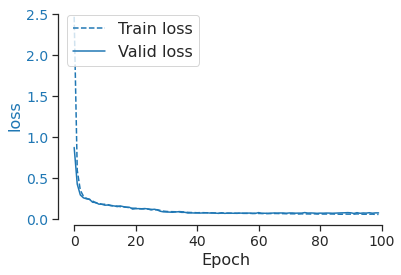

In [ ]:
plt, fig = sp.plot_metric(history, metric='loss')
fig.savefig('sparse_cnn_encoder_classifier_loss.pdf', bbox_inches='tight')

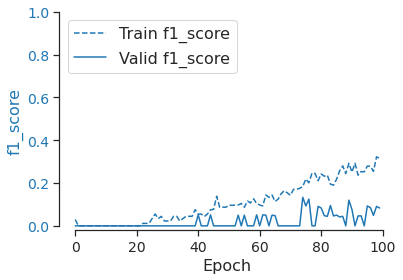

In [ ]:
plt, fig = sp.plot_metric(history, metric='f1_score', ylim=[0., 1.])
fig.savefig('sparse_cnn_encoder_classifier_f1_score.pdf', bbox_inches='tight')

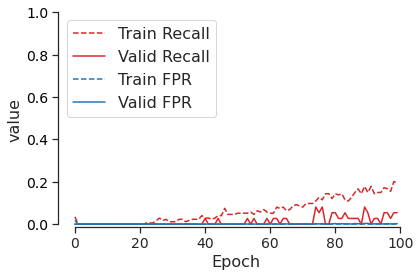

In [ ]:
plt, fig = sp.plot_model_recall_fpr(history)
fig.savefig('sparse_cnn_encoder_classifier_recall_fpr.pdf', bbox_inches='tight')